In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os,random,math
import collections
import nltk
from nltk import word_tokenize as tokenize
from nltk import sent_tokenize
import numpy as np
import operator
import pandas as pd, csv
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Microsoft Sentence Completion Challenge

File and directory paths required

In [ ]:
PARENT_DIR = "/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/Week 2/sentence-completion/"
TRAINING_DIR = "/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/Week 2/sentence-completion/Holmes_Training_Data"

questions_file = "/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/Week 2/sentence-completion/testing_data.csv"
answers_file = "/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/Week 2/sentence-completion/test_answer.csv"

results_directory = "/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/Assignment"

# N-gram models: unigram, bigram, and trigram


In [ ]:
def get_training_testing(training_dir,split=0.5):
  """
  split between train and test data given some files
  """

  filenames=os.listdir(training_dir)
  n=len(filenames)
  print("There are {} files in the training directory: {}".format(n,training_dir))
  random.seed(53)  #if you want the same random split every time
  random.shuffle(filenames)
  index=int(n*split)
  trainingfiles=filenames[:index]
  heldoutfiles=filenames[index:]
  return trainingfiles,heldoutfiles


class language_model():
    """
    Language model to train a unigram, a bigram, and a trigram model using 
    Kneser-ney smothing, absolute discount, and an out of vocabulary threshold
    to only include words that appeared more than 'n' times in the corpus
    """
    
  def __init__(self,known=2,discount=0.75,trainingdir=TRAINING_DIR,files=[]):
    self.training_dir = trainingdir
    self.files = files
    self.discount = discount
    self.known = known
    self.train()
      
  def train(self):
    """
    Train each ngram model
    """    
    self.unigram = {}
    self.bigram = {}
    self.trigram = {}
    
    self.count_token = {}

    self._processfiles()
    self._make_unknowns()
    self._kneser_ney()
    
    self._convert_to_probs()
    
  
  def _processline(self,line):
    """
    Get ngramms for each line of the document
    """
    tokens = ["__START"] + tokenize(line) + ["__END"]
    previous = "__END"
    pre_trigram = ["__END", "__END"]
    for token in tokens:
      # Get unigrams
      self.unigram[token] = self.unigram.get(token,0) + 1

      # Count tokens
      self.count_token[token] = self.count_token.get(token,0) + 1
      
      # Get bigrams
      current_big = self.bigram.get(previous,{})
      current_big[token] = current_big.get(token,0) + 1
      self.bigram[previous] = current_big

      # Get trigrams
      pre_trigram[1], pre_trigram[0] = pre_trigram[0], pre_trigram[1]
      pre_trigram[1] = previous

      current_tri = self.trigram.get(tuple(pre_trigram), {})
      current_tri[token] = current_tri.get(token, 0) + 1
      self.trigram[tuple(pre_trigram)] = current_tri

      previous = token
  
  def _processfiles(self):
    """
    Process files
    """
    for afile in self.files:
        try:
            with open(os.path.join(self.training_dir,afile)) as instream:
                for line in instream:
                    line = line.rstrip()
                    if len(line) > 0:
                        self._processline(line)
        except UnicodeDecodeError:
            print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
  
          
  def _convert_to_probs(self):
    """
    Conver ngram counts to probabilities
    """
      
    self.unigram = {k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
    self.bigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
    self.trigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
    self.kn = {k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
    self.kn_tri = {k:v/sum(self.kn_tri.values()) for (k,v) in self.kn_tri.items()}
    
    
  def get_prob(self,token,context="",methodparams={}):
    """
    Get the probability of a token given its context, an ngram method and 
    a smoothing technique 
    """
    if methodparams.get("method","unigram") == "unigram":
      return self.unigram.get(token,self.unigram.get("__UNK",0))
    
    elif methodparams.get("method","bigram") == "bigram": 
      if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
        unidist = self.kn
      else:
        unidist = self.unigram

      bigram = self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
      big_p = bigram.get(token,bigram.get("__UNK",0))
      lmbda = bigram["__DISCOUNT"]
      uni_p = unidist.get(token,unidist.get("__UNK",0))
      p = big_p + lmbda * uni_p            
      return p

    elif methodparams.get("method","trigram") == "trigram":
      if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
        unidist = self.kn_tri
        unidist_bi = self.kn
      else:
        unidist_bi = self.unigram

      if len(context) < 2:
        context = ["__END", context[0]]
      trigram = self.trigram.get(tuple(context[-2:]),self.trigram.get("__UNK",{}))
      trig_p = trigram.get(token,trigram.get("__UNK",0))
      lmbda_tri = trigram["__DISCOUNT"]

      bigram = self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
      big_p = bigram.get(token,bigram.get("__UNK",0))
      lmbda_bi = bigram["__DISCOUNT"]
      uni_p = unidist_bi.get(token,unidist_bi.get("__UNK",0))

      p = trig_p + (lmbda_tri * big_p) + (lmbda_bi * uni_p)      
      return p
  
  def compute_prob_line(self,line,methodparams={}):
    """
    Compute the probability of each line of the document
    """
    # Add _start to the beginning of a line of text
    # Compute the probability of the line according to the desired model
    # and returns probability together with number of tokens
    
    tokens = ["__START"] + tokenize(line) + ["__END"]
    acc = 0
    for i,token in enumerate(tokens[1:]):
        acc += math.log(self.get_prob(token,tokens[:i+1],methodparams))
    return acc,len(tokens[1:])
  
  def compute_probability(self,filenames=[],methodparams={}):
    # computes the probability (and length) of a corpus contained in filenames
    if filenames == []:
        filenames = self.files
    
    total_p = 0
    total_N = 0
    for i,afile in enumerate(filenames):
        try:
            with open(os.path.join(self.training_dir,afile)) as instream:
                for line in instream:
                    line = line.rstrip()
                    if len(line) > 0:
                        p,N = self.compute_prob_line(line,methodparams=methodparams)
                        total_p += p
                        total_N += N
        except UnicodeDecodeError:
            print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
    return total_p,total_N
  
  def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
    """
    Compute perplexity of given data
    """
    # Lower perplexity means that the model better explains the data
    
    p, N = self.compute_probability(filenames=filenames,methodparams=methodparams)
    #print(p,N)
    pp = math.exp(-p/N)
    return pp  
  
  def _make_unknowns(self):
    """
    Make unknown words given some threshold
    """
    unknown = 0
    self.number_unknowns = 0
    for (k,v) in list(self.unigram.items()):
      if v < self.known:
        del self.unigram[k]
        self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
        self.number_unknowns += 1

    for (k,adict) in list(self.bigram.items()):
      for (kk,v) in list(adict.items()):
        isknown = self.unigram.get(kk,0)
        if isknown == 0 and not kk == "__DISCOUNT":
          adict["__UNK"] = adict.get("__UNK",0) + v
          del adict[kk]
      isknown = self.unigram.get(k,0)
      if isknown == 0:
        del self.bigram[k]
        current = self.bigram.get("__UNK",{})
        current.update(adict)
        self.bigram["__UNK"] = current
      else:
        self.bigram[k] = adict

    for (k,adict) in list(self.trigram.items()):
      for (kk,v) in list(adict.items()):
        isknown = self.unigram.get(kk,0)
        if isknown == 0 and not kk == "__DISCOUNT":
          adict["__UNK"] = adict.get("__UNK",0) + v
          del adict[kk]
      prev_1, prev_2 = k
      isknown_1, isknown_2 = self.unigram.get(prev_1,0), self.unigram.get(prev_2,0)
      if isknown_1 == 0 or isknown_2 == 0:
        del self.trigram[k]
        current = self.trigram.get("__UNK",{})
        current.update(adict)
        self.trigram["__UNK"] = current
      else:
        self.trigram[k] = adict
        
              
  def _kneser_ney(self):
    """
    Apply absolute discount and kneser-Ney smoothing
    """
    # Discount each bigram count by a small fixed amount
    self.bigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.bigram.items()}

    # Discount each trigram count by a small fixed amount
    self.trigram = {k:{kk:value-self.discount for (kk,value) in adict.items()} for (k,adict) in self.trigram.items()}
    
    # For each word, store the total amount of the discount so that the total is the same 
    # i.e., so we are reserving this as probability mass
    for k in self.bigram.keys():
        lamb = len(self.bigram[k])
        self.bigram[k]["__DISCOUNT"] = lamb * self.discount
              
    for k in self.trigram.keys():
        lamb = len(self.trigram[k])
        self.trigram[k]["__DISCOUNT"] = lamb * self.discount

    # Work out kneser-ney unigram probabilities
    # Count the number of contexts each word has been seen in
    self.kn = {}
    for (k,adict) in self.bigram.items():
      for kk in adict.keys():
        self.kn[kk] = self.kn.get(kk,0) + 1

    self.kn_tri = {}
    for (k,adict) in self.trigram.items():
      for kk in adict.keys():
        self.kn_tri[kk] = self.kn_tri.get(kk,0) + 1

In [ ]:
class question:
    
  def __init__(self,aline):
    self.fields=aline
  
  def get_field(self,field):
    return self.fields[question.colnames[field]]
  
  def add_answer(self,fields):
    self.answer=fields[1]

  def get_tokens(self):
    return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

  def get_left_context(self,window=1,target="_____"):
    found = -1
    sent_tokens = self.get_tokens()
    for i,token in enumerate(sent_tokens):
        if token == target:
            found = i
            break  
        
    if found >- 1:
        return sent_tokens[i-window:i]
    else:
        return []

  def get_right_context(self,window=1,target="_____"):
    found = -1
    sent_tokens = self.get_tokens()
    for i,token in enumerate(sent_tokens):
      if token == target:
        found = i
        break  
      
    if found >- 1:
      return sent_tokens[found + 1:found + window + 1]
        
    else:
      return []

  # Choose model
  def choose(self,lm,method="bigram",smoothing="Kneser-ney", choices=[]):
    """
    Choose specific ngram to get the predicted answer for a given sentence 
    """
    if choices == []:
      choices = ["a","b","c","d","e"]

    if method == "bigram":
      rc = self.get_right_context(window=1)
      lc = self.get_left_context(window=1)
      probs = [lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) * lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]

    elif method == "trigram":
      rc = self.get_right_context(window=2)
      lc = self.get_left_context(window=2)
      probs = [lm.get_prob(self.get_field(ch+")"), lc, methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[0], [lc[-1]] + [self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[1], [self.get_field(ch+")")] + [rc[0]],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]
    
    else:
      context = self.get_left_context(window=1)
      probs = [lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
    
    maxprob = max(probs)
    bestchoices = [ch for ch,prob in zip(choices,probs) if prob == maxprob]

    return np.random.choice(bestchoices), probs
    
  def predict(self,lm,method="bigram", smoothing="kneser-ney"):
    """
    Predict the answer given a language model, a specific ngram and
    Kneser-Ney smoothing
    """
    return self.choose(lm,method=method,smoothing=smoothing,choices=[])

  def predict_and_score(self,lm,method="bigram", smoothing="kneser-ney"):
    """
    returns 1 if the prediction is equal to the answer and 0 otherwise. Also,
    it returns the prediction (letter) and the probability assigned to each
    option
    """
    prediction, probs = self.predict(lm,method=method,smoothing=smoothing)

    if prediction == self.answer:
      return 1, prediction, probs
    else:
      return 0, prediction, probs

class scc_reader:
    
  def __init__(self,qs,ans):
    self.qs=qs
    self.ans=ans
    self.read_files()
    
  def read_files(self):
      
    #read in the question file
    with open(self.qs) as instream:
      csvreader=csv.reader(instream)
      qlines=list(csvreader)
    
    #store the column names as a reverse index so they can be used to reference parts of the question
    question.colnames={item:i for i,item in enumerate(qlines[0])}
    
    #create a question instance for each line of the file (other than heading line)
    self.questions=[question(qline) for qline in qlines[1:]]
    
    #read in the answer file
    with open(self.ans) as instream:
      csvreader=csv.reader(instream)
      alines=list(csvreader)
        
    #add answers to questions so predictions can be checked    
    for q,aline in zip(self.questions,alines[1:]):
      q.add_answer(aline)
      
  def get_field(self,field):
    return [q.get_field(field) for q in self.questions] 
  
  def predict(self,method="bigram"):
    return [q.predict(method=method) for q in self.questions]
  
  def predict_and_score(self,lm,method="bigram",smoothing="kneser-ney"):
    """
    Return the accuracy of the ngram, along with all its predictions and the 
    probability distribution of the options of each question
    """
    predictions = []
    scores = []
    total_probs = []
    for q in self.questions:
      score, pred, probs = q.predict_and_score(lm,method=method, smoothing=smoothing)
      scores.append(score)
      predictions.append(pred)
      total_probs.append(probs)

    return sum(scores)/len(scores), predictions, total_probs
  

Tune Ngram hyperparameters: OOV threshold, abosule discount, and smoothing technique.  

In [ ]:
# Tuning Hyperparameters
fls = os.listdir(TRAINING_DIR)
number_files = np.linspace(10, 100, 3).astype(int)
known = [2, 3, 4]
discount = 0.75
smoothing = 'kneser-ney'
MAX_FILES = 2
results = []
predictions = []
total_probs = []
iter = 0
for n in number_files:
  for k in known:
    print('Processing {} documents...'.format(n))
    mylm = language_model(known=k, discount=discount, files=fls[:n])
    SCC = scc_reader(questions_file, answers_file)
    
    unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
    bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing=smoothing)
    trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing=smoothing)
    
    results.append((n, k, unigram_accuracy, bigram_accuracy, trigram_accuracy))
    predictions.append((unigram_predictions, bigram_predictions, trigram_predictions))
    total_probs.append((unigram_probs, bigram_probs, trigram_probs))

    iter += 1

Processing 10 documents...
Processing 10 documents...
Processing 10 documents...
Processing 55 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
Processing 55 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
Processing 55 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
Processing 100 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
Processing 100 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
Processing 100 documents...
UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file


In [ ]:
cols = ['number of files', 'OOV threshold', 'unigram accuracy', 'bigram accuracy', 'trigram accuracy']
values = results
df = pd.DataFrame(values, columns=cols)
display(df) 

,number of files,OOV threshold,unigram accuracy,bigram accuracy,trigram accuracy
0,10,2,0.225962,0.206731,0.213462
1,10,3,0.195192,0.190385,0.202885
2,10,4,0.189423,0.179808,0.211538
3,55,2,0.237500,0.223077,0.257692
4,55,3,0.240385,0.215385,0.242308
5,55,4,0.237500,0.213462,0.239423
6,100,2,0.240385,0.208654,0.265385
7,100,3,0.245192,0.210577,0.259615
8,100,4,0.244231,0.208654,0.240385


Get accuracies for the Ngram models with the tuned hyperparameters and save the results in a CSV file

In [ ]:
known = 2
discount = 0.75
smoothing = 'kneser-ney'

mylm = language_model(known=known, discount=discount, files=fls)
SCC = scc_reader(questions_file, answers_file)

unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing=smoothing)
trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing=smoothing)

# Save results in a csv file
with open(os.path.join(results_directory, 'SCC_results.csv'), 'w') as out:
  writer = csv.writer(out, delimiter=',')
  writer.writerow(['id', 'answer unigiram', 'probs unigram', 'answer bigram', 'probs bigram', 'answer trigram', 'probs trigram'])
  for i in range(len(unigram_predictions)):
    writer.writerow([str(i+1), unigram_predictions[i], unigram_probs[i], bigram_predictions[i], 
                      bigram_probs[i], trigram_predictions[i], trigram_probs[i]])

UnicodeDecodeError processing ACHOE10.TXT: ignoring rest of file
UnicodeDecodeError processing DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing KRSON10.TXT: ignoring rest of file
UnicodeDecodeError processing HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file
UnicodeDecodeError processing LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing MOHIC10.TXT: ignoring rest of file
UnicodeDecodeError processing PHIL410.TXT: ignoring rest of file
UnicodeDecodeError processing TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing TBTAS10.TXT: ignoring rest of file
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file


# word2vec model

In [ ]:
import argparse
import time
import csv
import ast
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, normalize
from scipy import spatial
import numpy as np
from gensim.models import Word2Vec, KeyedVectors

Load Google News and Holmes models

In [ ]:
google_embeddings = '/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/GoogleNews-vectors-negative300.bin'
holmes_embeddings = '/content/drive/My Drive/Sussex AI/Spring Semester/Advanced NLP/holmes_model.bin'

print("Loading pretrained embeddings")
# Load pretrained word embeddings
model_google_news = KeyedVectors.load_word2vec_format(google_embeddings, binary=True)
model_holmes = KeyedVectors.load(holmes_embeddings)
# Normalize holmes embeddings
model_holmes.init_sims(replace=True)

Loading pretrained embeddings


In [ ]:
def get_embeddings(tokens, google_embeddings, holmes_embeddings, google_emb=True, holmes_emb=False):
  """
  Get the selected embedding for each token in the sentence
  """
  dim = google_embeddings['woman'].size
  word_vec = []
  for word in tokens:
    if google_emb and word in google_embeddings:
      word_vec.append(google_embeddings[word])

    elif holmes_emb and word in holmes_embeddings:
      word_vec.append(holmes_embeddings[word])

    else:
      word_vec.append(np.random.uniform(-1,1,dim))

  return word_vec

def total_similarity(vec, ques_vec):
  """
  Compute the total similarity
  """
  score = 0
  for v in ques_vec:
    cosine_similarity = 1 - spatial.distance.cosine(vec, v)

    score += cosine_similarity

  return score

def total_similarity_average(candidate, vectors):
  """
  Compute the average total similarity
  """
  sum_embeddings = 0
  for vect in vectors:
    sum_embeddings += vect

  average_sentence_embedding = sum_embeddings / len(vectors)
  
  score = 1 - spatial.distance.cosine(average_sentence_embedding, candidate)

  return score

In [ ]:
def word2vec_predictions(embedding1, embedding2, google, holmes,
                         average_similarity=False):
  """
  Get predictions, accuracy, and scores of the options 
  """

  total_scores = []
  with open(answers_file) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)

  qs_df = pd.DataFrame(lines[1:],columns=lines[0])
  answers = np.array(qs_df['answer'])

  keys = ['a)', 'b)', 'c)', 'd)', 'e)']
  choices = ['a', 'b', 'c', 'd', 'e']
  predictions = []

  print("Predicting answers")

  with open(questions_file) as qf:
    csvreader = csv.reader(qf)
    lines = list(csvreader)

  qs_df = pd.DataFrame(lines[1:],columns=lines[0])
  questions = list(qs_df['question'])

  for i,question in enumerate(questions):
    tokens = tokenize(question)
    # Get question embeddings
    ques_vec = get_embeddings(tokens, embedding1, embedding2, google, holmes)

    scores = []
    candidates = [qs_df[x][i] for x in keys]

    # Get candidate word embeddings
    cand_vec = get_embeddings(candidates, embedding1, embedding2, google, holmes)

    # Calculate total word similarity
    for word in cand_vec:
      if not average_similarity:
        s = total_similarity(word, ques_vec)
      else:
        s = total_similarity_average(word, ques_vec)    

      scores.append(s)
    
    idx = scores.index(max(scores))
    ans = choices[idx]
    predictions.append(ans)

    total_scores.append(scores)

    accuracy = np.sum(predictions == np.array(answers)) / len(predictions) * 100

  return np.array(predictions), accuracy, total_scores

Tune hyperparameters

In [ ]:
results = []
pred_scores = []
google = [False, True]
holmes = [False, True]
avt = [False, True]
word2vec_scores = []
for g in google:
  for h in holmes:
    if not g and not h:
      continue
    for sim in avt:
      print('Google', g, 'Holmes', h, 'Sim', sim)
      predictions, accuracy, scores = word2vec_predictions(model_google_news, model_holmes, g, h, sim)
      results.append((g, h, sim, accuracy))
      pred_scores.append((predictions, scores))

Google False Holmes True Sim False
Predicting answers


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Google False Holmes True Sim True
Predicting answers
Google True Holmes False Sim False
Predicting answers
Google True Holmes False Sim True
Predicting answers
Google True Holmes True Sim False
Predicting answers
Google True Holmes True Sim True
Predicting answers


In [ ]:
cols = ['Google embeddings', 'Holmes embeddings', 'Average total similarity', 'Word2Vec accuracy']
values = results
df = pd.DataFrame(values, columns=cols)
display(df) 

,Google embeddings,Holmes embeddings,Average total similarity,Word2Vec accuracy
0,False,True,False,36.826923
1,False,True,True,33.461538
2,True,False,False,34.038462
3,True,False,True,28.750000
4,True,True,False,33.076923
5,True,True,True,35.961538


Append the results to the CSV files with the ngram results

In [ ]:
w2v_predictions, w2v_scores = pred_scores[0]

# Save results in a csv file
df = pd.read_csv(os.path.join(results_directory, 'SCC_results.csv'), delimiter=',')
# this line creates a new column, which is a Pandas series.
df['answer Word2Vec'] = w2v_predictions
df['scores Word2Vec'] = w2v_scores

# save the dataframe to CSV
df.to_csv(os.path.join(results_directory, 'SCC_results.csv'), sep=',', index=False)

# Compare results: Ngram vs. Word2Vec

In [ ]:
df = pd.read_csv(os.path.join(results_directory, 'SCC_results.csv'), delimiter=',')

In [ ]:
predictions_uni, predictions_bi, predictions_tri, predictions_w2v = df['answer unigram'], df['answer bigram'], df['answer trigram'], df['answer Word2Vec']
scores_uni, scores_bi, scores_tri, scores_w2v = df['probs unigram'], df['probs bigram'], df['probs trigram'], df['scores Word2Vec']

In [ ]:
def get_accuracy(predicts):
  """
  Get accuracy for a set of predictions
  """
  with open(answers_file) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)

  ans_df = pd.DataFrame(lines[1:],columns=lines[0])
  answers = np.array(ans_df['answer'])

  return np.sum(predicts == answers) / len(answers)

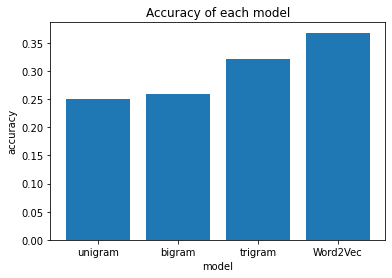

In [ ]:
uni_accuracy = get_accuracy(predictions_uni)
bi_accuracy = get_accuracy(predictions_bi)
tri_accuracy = get_accuracy(predictions_tri)
w2v_accuracy = get_accuracy(predictions_w2v)

plt.bar(['unigram', 'bigram', 'trigram', 'Word2Vec'], [uni_accuracy, bi_accuracy, tri_accuracy, w2v_accuracy])
plt.title('Accuracy of each model')
plt.xlabel('model')
plt.ylabel('accuracy')
plt.show()

In [ ]:
def compare_predictions(predicts1, predicts2):
  """
  Make comparisons between two sets of predictions
  """

  with open(answers_file) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)

  ans_df = pd.DataFrame(lines[1:],columns=lines[0])
  answers = np.array(ans_df['answer'])
  
  general_comparison = np.sum(np.array(predicts1) == np.array(predicts2)) / len(predicts1) * 100

  right_ans_shared = np.array([1 if answers[i] == predicts1[i] and predicts1[i] == predicts2[i] else 0 for i in range(len(predicts1))])
  wrong_ans_shared = np.array([1 if answers[i] != predicts1[i] and predicts1[i] == predicts2[i] else 0 for i in range(len(predicts1))])

  return general_comparison, np.sum(right_ans_shared) / len(predicts1) * 100, np.sum(wrong_ans_shared) / len(predicts1) * 100

In [ ]:
# Get shared errors between the different models
compare_tri_uni, common_right_tri_uni, common_errors_tri_uni = compare_predictions(predictions_tri, predictions_uni)
compare_tri_bi, common_right_tri_bi, common_errors_tri_bi = compare_predictions(predictions_tri, predictions_bi)
compare_w2v_uni, common_right_w2v_uni, common_errors_w2v_uni = compare_predictions(predictions_w2v, predictions_uni)
compare_w2v_bi, common_right_w2v_bi, common_errors_w2v_bi = compare_predictions(predictions_w2v, predictions_bi)
compare_w2v_tri, common_right_w2v_tri, common_errors_w2v_tri = compare_predictions(predictions_w2v, predictions_tri)

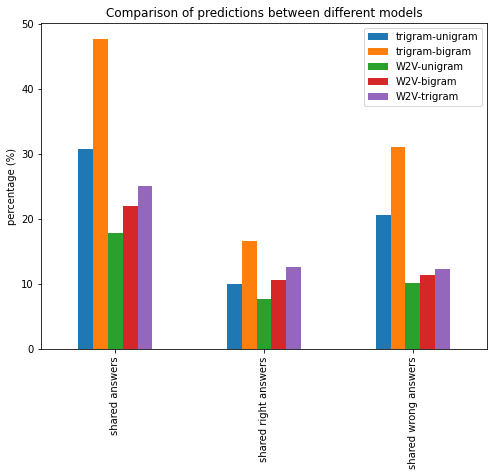

In [ ]:
X = ['shared answers', 'shared right answers', 'shared wrong answers']
Y = [compare_tri_uni, compare_tri_bi, compare_w2v_uni, compare_w2v_bi, compare_w2v_tri] 
Z = [common_right_tri_uni, common_right_tri_bi, common_right_w2v_uni, common_right_w2v_bi, common_right_w2v_tri]
T = [common_errors_tri_uni, common_errors_tri_bi, common_errors_w2v_uni, common_errors_w2v_bi, common_errors_w2v_tri]

labels = ['trigram-unigram', 'trigram-bigram', 'W2V-unigram', 'W2V-bigram', 'W2V-trigram']

df = pd.DataFrame((Y,Z,T), index=X, columns=labels)
ax = df.plot(kind='bar', figsize=(8, 6))
ax.set_ylabel('percentage (%)')
ax.set_title('Comparison of predictions between different models')
plt.show()

In [ ]:
def analyze_errors(predicts, scores, model='ngram'):
  """
  Get error inidices and the uncertainty of the correct answer when a wrong
  option has been predicted
  """
  keys = ['a', 'b', 'c', 'd', 'e']
  with open(answers_file) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)

  ans_df = pd.DataFrame(lines[1:],columns=lines[0])
  answers = np.array(ans_df['answer'])

  errors = []
  uncertainty_correct_ans = []
  for i in range(len(predicts)):
    if answers[i] != predicts[i]:
      errors.append(i)
      ind_correct = keys.index(answers[i])
      # Get the uncertatinty of the correct answer
      if model == 'ngram':
        uncertainty_correct_ans.append(-np.log2(normalize_probs(scores[i])[ind_correct]))

      else:
        uncertainty_correct_ans.append(-np.log2(normalize_scores(scores[i])[ind_correct]))

  return uncertainty_correct_ans, errors

In [ ]:
def normalize_scores(scores):
  """
  Normalize scores obtained from cosine similarity
  """
  scores = ast.literal_eval(scores)
  norm_scores = np.array(scores) + abs(min(scores)) + 1

  return norm_scores / np.sum(norm_scores)

In [ ]:
def normalize_probs(probs):
  """
  Normalize probabilities obtained from an ngram model
  """
  probs = ast.literal_eval(probs)
  prob_factor = 1 / sum(probs)

  return [prob_factor * p for p in probs]

In [ ]:
def entropy(probs):
  """
  Compute entropy of a given probability distribution
  """
  return np.sum(-np.log2(probs) * probs)

In [ ]:
# Get uncertainties for the correct answer when an impostor has been chosen
uncer_uni, errors_uni = analyze_errors(predictions_uni, scores_uni, 'ngram')
uncer_bi, errors_bi = analyze_errors(predictions_bi, scores_bi, 'ngram')
uncer_tri, errors_tri = analyze_errors(predictions_tri, scores_tri, 'ngram')
uncer_w2v, errors_w2v = analyze_errors(predictions_w2v, scores_w2v, 'w2v')

In [ ]:
# Compute average uncertainty for each model
av_uncer_uni = np.mean(uncer_uni)
av_uncer_bi = np.mean(uncer_bi)
av_uncer_tri = np.mean(uncer_tri)
av_uncer_w2v = np.mean(uncer_w2v)

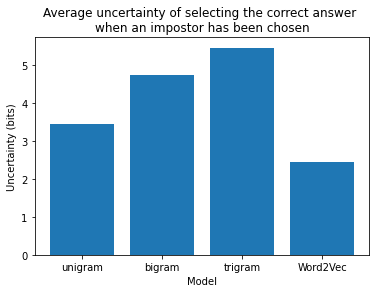

In [ ]:
plt.bar(['unigram', 'bigram', 'trigram', 'Word2Vec'], [av_uncer_uni, av_uncer_bi, av_uncer_tri, av_uncer_w2v])
plt.title('Average uncertainty of selecting the correct answer \nwhen an impostor has been chosen')
plt.xlabel('Model')
plt.ylabel('Uncertainty (bits)')
#plt.ylim(0, baseline_entropy)
#plt.yticks(np.arange(0, baseline_entropy, 0.2))
plt.show()

Examine random questions where certain model fails

In [ ]:
with open(questions_file) as instream:
  csvreader = csv.reader(instream)
  lines = list(csvreader)

qs_df = pd.DataFrame(lines[1:],columns=lines[0])

with open(answers_file) as instream:
  csvreader = csv.reader(instream)
  lines = list(csvreader)

ans_df = pd.DataFrame(lines[1:],columns=lines[0])

In [ ]:
# Select a random question that the model has failed
random_wrong = np.random.choice(errors_tri)
question = qs_df.loc[random_wrong, 'question']
answers = list(qs_df.iloc[random_wrong, 2:7].items())
print('Question:', question)
print('\n',answers)
print('***')
print('Correct:', ans_df.iloc[random_wrong, 1])
print('Incorrect trigram:', predictions_tri[random_wrong])
print('Incorrect W2V:', predictions_w2v[random_wrong])

Question: His face set hard , and a baleful light _____ up in his grey eyes.

 [('a)', 'tiptoed'), ('b)', 'wrapped'), ('c)', 'sprang'), ('d)', 'smiled'), ('e)', 'pursed')]
***
Correct: c
Incorrect trigram: b
Incorrect W2V: b


Check whether the errors are due to the length of the questions

In [ ]:
len_errors_uni = np.mean([len(qs_df.loc[error, 'question'].split()) for error in errors_uni])
len_errors_bi = np.mean([len(qs_df.loc[error, 'question'].split()) for error in errors_bi])
len_errors_tri = np.mean([len(qs_df.loc[error, 'question'].split()) for error in errors_tri])
len_errors_w2v = np.mean([len(qs_df.loc[error, 'question'].split()) for error in errors_w2v])

In [ ]:
len_correct_uni = np.mean([len(qs_df.loc[i, 'question'].split()) for i in range(len(predictions_uni)) if i not in errors_uni])
len_correct_bi = np.mean([len(qs_df.loc[i, 'question'].split()) for i in range(len(predictions_uni)) if i not in errors_bi])
len_correct_tri = np.mean([len(qs_df.loc[i, 'question'].split()) for i in range(len(predictions_uni)) if i not in errors_tri])
len_correct_w2v = np.mean([len(qs_df.loc[i, 'question'].split()) for i in range(len(predictions_uni)) if i not in errors_w2v])

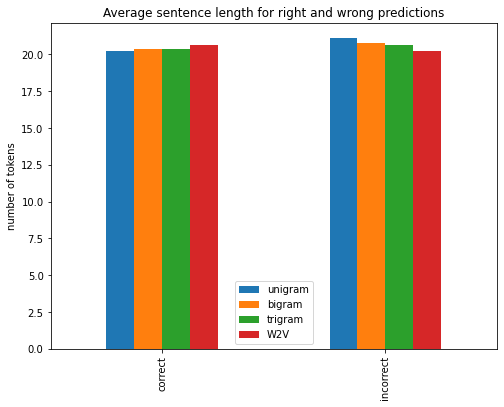

In [ ]:
labels = ['unigram', 'bigram', 'trigram', 'W2V']
X = ['correct', 'incorrect']

Y = [len_errors_uni, len_errors_bi, len_errors_tri, len_errors_w2v] 
Z = [len_correct_uni, len_correct_bi, len_correct_tri, len_correct_w2v]

df = pd.DataFrame((Y,Z), index=X, columns=labels)
ax = df.plot(kind='bar', figsize=(8, 6))
ax.set_ylabel('number of tokens')
ax.set_title('Average sentence length for right and wrong predictions')
plt.show()

Entropy baseline (i.e., random answer is chosen)

In [ ]:
# Since there are 5 options, the maximum entropy (i.e., random answer) will be
# when the same probability is assigned to each option (i.e., uniform distribution)
baseline_entropy = entropy(np.full(5, 1/5))
print('Entropy baseline for random answer is {}.'.format(baseline_entropy))

Entropy baseline for random answer is 2.321928094887362.


In [ ]:
# Get average entropy for each model
uni_av_entropy = []
bi_av_entropy = []
tri_av_entropy = []
w2v_av_entropy = []

for i in range(len(scores_uni)):
  uni_av_entropy.append(entropy(normalize_probs(scores_uni[i])))
  bi_av_entropy.append(entropy(normalize_probs(scores_bi[i])))
  tri_av_entropy.append(entropy(normalize_probs(scores_tri[i])))
  w2v_av_entropy.append(entropy(normalize_scores(scores_w2v[i])))

# Get entropy average for each model
uni_av_entropy = np.mean(uni_av_entropy)
bi_av_entropy = np.mean(bi_av_entropy)
tri_av_entropy = np.mean(tri_av_entropy)
w2v_av_entropy = np.mean(w2v_av_entropy)

Compute the average entropy of the predictions for all question in each model

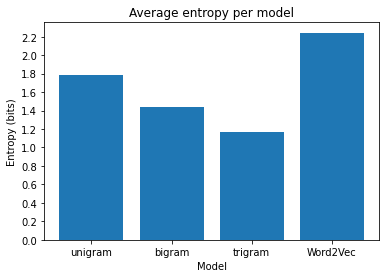

In [ ]:
plt.bar(['unigram', 'bigram', 'trigram', 'Word2Vec'], [uni_av_entropy, bi_av_entropy, tri_av_entropy, w2v_av_entropy])
plt.title('Average entropy per model')
plt.xlabel('Model')
plt.ylabel('Entropy (bits)')
#plt.ylim(0, baseline_entropy)
plt.yticks(np.arange(0, baseline_entropy, 0.2))
plt.show()